In [50]:
import numpy as np
import torch 
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils

In [53]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])

train_data = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

test_data = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,
                                          shuffle=True,num_workers=2)

test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,
                                          shuffle=True,num_workers=2)

In [54]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)#两个池化，所以是7*7而不是14*14
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
#       self.dp = nn.Dropout(p=0.5)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的 
        x = F.relu(self.fc1(x))
#       x = self.fc3(x)
#       self.dp(x)
        x = F.relu(self.fc2(x))   
        x = self.fc3(x)  
#       x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x

net = CNN()

In [55]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#也可以选择Adam优化方法
# optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)

In [97]:
train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(3):
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0是下标起始位置默认为0
        # data 的格式[[inputs, labels]]       
#         inputs,labels = data
        inputs,labels = data[0].to(device), data[1].to(device)
        #初始为0，清除上个batch的梯度信息
        optimizer.zero_grad()         

        #前向+后向+优化     
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # loss 的输出，每个一百个batch输出，平均的loss
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d,%5d] loss :%.3f' %
                 (epoch+1,i+1,running_loss/100))
            running_loss = 0.0
        train_loss.append(loss.item())

        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)

print('Finished Training')

[1,  100] loss :2.293
[1,  200] loss :2.267
[1,  300] loss :2.213
[1,  400] loss :2.061
[1,  500] loss :1.544
[1,  600] loss :0.870
[1,  700] loss :0.567
[1,  800] loss :0.439
[1,  900] loss :0.386
[2,  100] loss :0.332
[2,  200] loss :0.314
[2,  300] loss :0.289
[2,  400] loss :0.260
[2,  500] loss :0.240
[2,  600] loss :0.228
[2,  700] loss :0.228
[2,  800] loss :0.211
[2,  900] loss :0.185
[3,  100] loss :0.176
[3,  200] loss :0.153
[3,  300] loss :0.174
[3,  400] loss :0.161
[3,  500] loss :0.139
[3,  600] loss :0.137
[3,  700] loss :0.132
[3,  800] loss :0.145
[3,  900] loss :0.126
Finished Training


In [98]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

the munber is:  7
predict is:  tensor(7)


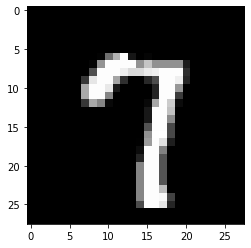

In [119]:
test_net = CNN()
test_net.load_state_dict(torch.load(PATH))

def print_img(img):
  grid = utils.make_grid(img)
  grid = grid.numpy().transpose(1,2,0) 
  std = [0.5]
  mean = [0.5]
  grid = grid * std + mean
  plt.imshow(grid)
  plt.show()

index = 9077
with torch.no_grad():
  img, label = train_data[index]
  output = test_net(img)
  _, predicted = torch.max(output, dim = 1)
  print("the munber is: ", str(label))
  print("predict is: ", predicted[0])
  print_img(img)

In [100]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = test_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
#         print(predicted == labels)
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 98 %
Accuracy of 1 : 98 %
Accuracy of 2 : 93 %
Accuracy of 3 : 99 %
Accuracy of 4 : 97 %
Accuracy of 5 : 96 %
Accuracy of 6 : 96 %
Accuracy of 7 : 95 %
Accuracy of 8 : 95 %
Accuracy of 9 : 97 %
